## Ana Carolina Erthal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import torch 
import torch.nn.functional as F
from torch.autograd.functional import hessian
from torch.distributions.multivariate_normal import MultivariateNormal
import seaborn as sns

# remove warnings
import warnings
warnings.filterwarnings('ignore')

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 03: Regressão logística e inferência Bayesiana aproximada

O pedaço de código abaixo carrega o banco de dados 'breast cancer' e adiciona uma coluna de bias. Além disse, ele o particiona em treino e teste.

1. Implemente a estimativa de máximo a posteriori para um modelo de regressão logística com priori $\mathcal{N}(0, c I)$ com $c=100$ usando esse banco de dados;
2. Implemente a aproximação de Laplace para o mesmo modelo;
3. Implemente uma aproximação variacional usando uma Gaussiana diagonal e o truque da reparametrização;
4. Calcule a accuracy no teste para todas as opções acima --- no caso das 2 últimas, a prob predita é $\int_\theta p(y|x, \theta) q(\theta)$;
5. Para cada uma das 3 técnicas, plote um gráfico com a distribuição das entropias para as predições corretas e erradas (separadamente), use a função kdeplot da biblioteca seaborn.
6. Comente os resultados, incluindo uma comparação dos gráficos das entropias.

Explique sua implementação também! 

Para facilitar sua vida: use PyTorch, Adam para otimizar (é uma variação SGD) com lr=0.001, use o banco de treino inteiro ao invés de minibatchces, use binary_cross_entropy_with_logits para implementar a -log verossimilhança, use torch.autograd.functional para calcular a Hessiana. Você pode usar as bibliotecas importadas na primeira célula a vontade. Verifique a documentação de binary_cross_entropy_with_logits para garantir que a sua priori está implementada corretamente, preservando as proporções devidas. Use 10000 amostras das aproximações para calcular suas predições.

In [2]:
data =  load_breast_cancer()
N = len(data.data)
Ntrain = int(np.ceil(N*0.6))
perm = np.random.permutation(len(data.data))
X = torch.tensor(data.data).float()
X = torch.cat((X, torch.ones((X.shape[0], 1))), axis=1) 
y = torch.tensor(data.target).float()
d = X.shape[1]

Xtrain, ytrain = X[perm[:Ntrain]], y[perm[:Ntrain]]
Xtest, ytest = X[perm[Ntrain:]], y[perm[Ntrain:]]

Criaremos, a princípio, a função de cálculo da entropia que será utilizada posteriormente para as plotagens de densidade de entropia:

In [3]:
def entropy(y_prob, y_pred):
    right_entropy = []
    wrong_entropy = []

    for i in range(y_prob.shape[0]):
        if y_pred[i] == ytest[i]:
            entropy = -y_prob[i] * torch.log(y_prob[i]) - (1-y_prob[i]) * torch.log(1-y_prob[i]) 
            entropy = entropy.detach().numpy() # makes it an array
            entropy = np.nan_to_num(entropy)
            right_entropy.append(entropy)
        else:
            entropy = -y_prob[i] * torch.log(y_prob[i]) - (1-y_prob[i]) * torch.log(1-y_prob[i])
            entropy = entropy.detach().numpy() # makes it an array
            entropy = np.nan_to_num(entropy)
            wrong_entropy.append(entropy) 
    
    right_entropy = np.array(right_entropy)
    wrong_entropy = np.array(wrong_entropy)

    return right_entropy, wrong_entropy

Faremos então o código para implementar o método de Máximo a Posteriori. Na prática, queremos encontrar o vetor de pesos para fazermos a predição utilizando o theta que maximiza a posteriori. Assim, partimos da priori fornecida, da verossimilhança calculada a partir dos logits e calculamos a posteriori para, então, otimizar. Note que calculamos, no algoritmo, a posteriori negativa para minimizar (o mesmo que maximizar a própria posteriori), e tudo em logs para possibilitar as contas.

In [4]:
# maximum a posteriori estimate for logistic regression
theta = torch.randn(d, requires_grad=True)
optimizer = torch.optim.Adam([theta], lr=0.001) 

for i in range(10000):
    optimizer.zero_grad()

    # get the logits between 0 and 1
    logits = Xtrain @ theta
    neg_log_likelihood = F.binary_cross_entropy_with_logits(logits, ytrain)
    # compute the log priori for the Multivariate Normal distribution with mean 0 and covariance = 100*Identity
    log_priori = MultivariateNormal(torch.zeros(d), 100*torch.eye(d)).log_prob(theta)
    neg_log_post = neg_log_likelihood - log_priori
    
    neg_log_post.backward()
    optimizer.step()

Nesse caso, é bem simples calcular a acurácia, já que basta calcular as probabilidades diretamente:

In [5]:
y_pred = (torch.sigmoid(Xtrain @ theta)) >= 0.5
print("Accuracy on train set: ", (y_pred == ytrain).sum().item()/len(ytrain))

Accuracy on train set:  0.9590643274853801


In [6]:
y_prob = torch.sigmoid(Xtest @ theta)
y_pred = (y_prob >= 0.5)
print("Accuracy on test set: ", (y_pred == ytest).sum().item()/len(ytest))

Accuracy on test set:  0.933920704845815


Vamos fazer, também, o gráfico de distribuição de entropia para as predições certas e erradas, armazenando os valores em uma lista para em seguida plotar:

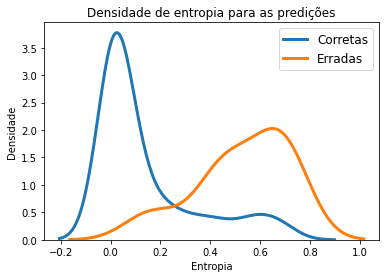

In [8]:
right_entropy, wrong_entropy = entropy(y_prob, y_pred)

sns.distplot(right_entropy, hist=False, kde=True,
                kde_kws={'linewidth': 3},
                label = 'Corretas')
sns.distplot(wrong_entropy, hist=False, kde=True,
                kde_kws={'linewidth': 3},
                label = 'Erradas')

plt.legend(prop={'size': 12})
plt.title('Densidade de entropia para as predições')
plt.xlabel('Entropia')
plt.ylabel('Densidade')
plt.show()

Faremos agora a aproximação de Laplace para regressão logística. Queremos melhorar o desempenho, então o método consiste em aproximar a posteriori utilizando uma série de Taylor de segunda ordem, e na prática utilizamos a solução do MAP como média e o inverso da hessiana referente a esse theta como parâmetros de uma normal multivariada como posteriori. 

Para calcular a accuracy, o processo é menos direto que na aplicação anterior, já que não obtemos as probabilidades de que um y pertença a uma classe diretamente, apenas a distribuição a posteriori. Assim, aplicamos Monte Carlo para, a partir das samples dessa distribuição, obtermos as probabilidades para aplicarmos a sigmoide e termos a predição. 

In [10]:
# laplace approximation for logistic regression

def posteriori(theta):
    logits = Xtrain @ theta
    neg_log_likelihood = F.binary_cross_entropy_with_logits(logits, ytrain)
    log_priori = MultivariateNormal(torch.zeros(d), 100*torch.eye(d)).log_prob(theta)
    return neg_log_likelihood - log_priori

hess = hessian(posteriori, theta)

# mean and covariance of the laplace approximation
mean = theta.detach().numpy().copy()
cov = torch.inverse(hess).detach().numpy().copy()

T = 10000

# monte carlo sampling from the laplace approximation
samples = np.random.multivariate_normal(mean, cov, size=T)
Xtheta = Xtrain @ torch.tensor(samples).float().t()

# gets the probability of the samples
y_prob = torch.sigmoid(Xtheta).mean(axis=1)
y_pred = torch.tensor(y_prob) >= 0.5
print("Accuracy on train set: ", (y_pred==ytrain).sum().item()/len(ytrain))
    

Accuracy on train set:  0.9619883040935673


Agora obtendo a acurácia para o conjunto de treino:

In [11]:
Xtheta = Xtest @ torch.tensor(samples).float().t()

#get the probability of the samples
y_prob = torch.sigmoid(Xtheta).mean(axis=1)
y_pred = torch.tensor(y_prob) >= 0.5
print("Accuracy on test set: ", (y_pred==ytest).sum().item()/len(ytest))

Accuracy on test set:  0.9295154185022027


Faremos, também, o gráfico da densidade de entropia:

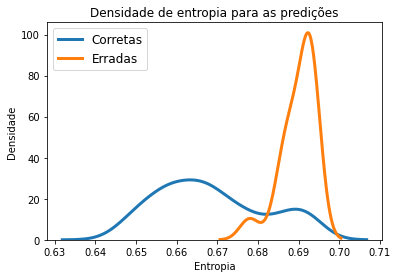

In [12]:
right_entropy, wrong_entropy = entropy(y_prob, y_pred)

sns.distplot(right_entropy, hist=False, kde=True,
                kde_kws={'linewidth': 3},
                label = 'Corretas')
sns.distplot(wrong_entropy, hist=False, kde=True,
                kde_kws={'linewidth': 3},
                label = 'Erradas')

plt.legend(prop={'size': 12})
plt.title('Densidade de entropia para as predições')
plt.xlabel('Entropia')
plt.ylabel('Densidade')
plt.show()

Por fim, faremos a implementação da regressão logística com inferência variacional, onde faremos uma aproximação da posteriori p com uma distribuição q, e tentaremos minimizar a divergência KL entre elas. Assim, começamos escolhendo os parâmetros utilizados na reparametrização para essa aproximação pela q, e definindo o otimizador Adam (assim como nas anteriores) para esses parâmetros, porém desta vez com um learning rate de 0.01, já que o recomendado não foi um bom hiperparâmetro nesse caso. Na prática, o que fazemos é minimizar a divergência KL, obtendo mu e c para, então, utilizá-los como média e variância de uma normal multivariada, obtendo as samples que buscamos para encontrarmos as probabilidades de que a predição pertença a uma classe ou outra utilizando Monte Carlo, como anteriormente, para por fim encontrarmos a accuracy.

In [13]:
# variational inference for logistic regression

mu = torch.randn(d, requires_grad=True)
c = torch.randn(d, requires_grad=True)

optimizer = torch.optim.Adam([mu, c], lr=0.01)

T = 100

for i in range(1000):
    optimizer.zero_grad()

    # variance
    ss = F.softplus(c)
    # sample from the gaussian diagonal distribution
    thetas = torch.randn(T, d) @ torch.diag(ss) + mu
    loss = 0

    for t in range(T):
        theta = thetas[t, :]
        logits = Xtrain @ theta
        
       # kullback leibler divergence 
        neg_log_likelihood = F.binary_cross_entropy_with_logits(logits, ytrain) 
        log_priori = MultivariateNormal(torch.zeros(d), 100*torch.eye(d)).log_prob(theta) 
        log_q = MultivariateNormal(mu, ss*torch.eye(d)).log_prob(theta)
        
        loss += (neg_log_likelihood + log_q - log_priori)/T 
    
    loss.backward()
    optimizer.step()

ss_cov = ss*torch.eye(d)
ss_cov = ss_cov.detach().numpy().copy()
mu_np = mu.detach().numpy().copy()

# monte carlo
samples = np.random.multivariate_normal(mu_np, ss_cov, size=10000)
Xtheta = Xtest @ torch.tensor(samples).float().t()

# get the probability of the samples
y_prob = torch.sigmoid(Xtheta).mean(axis=1)
y_pred = torch.tensor(y_prob) >= 0.5
print("Accuracy on test set: ", (y_pred==ytest).sum().item()/len(ytest))

Accuracy on test set:  0.8942731277533039


Por fim, faremos a última plotagem da entropia:

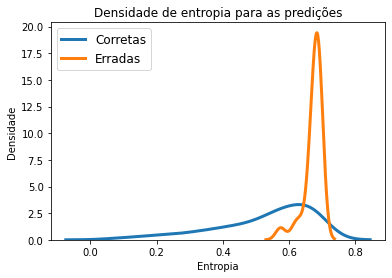

In [14]:
right_entropy, wrong_entropy = entropy(y_prob, y_pred)

sns.distplot(right_entropy, hist=False, kde=True,
                kde_kws={'linewidth': 3},
                label = 'Corretas')
sns.distplot(wrong_entropy, hist=False, kde=True,
                kde_kws={'linewidth': 3},
                label = 'Erradas')

plt.legend(prop={'size': 12})
plt.title('Densidade de entropia para as predições')
plt.xlabel('Entropia')
plt.ylabel('Densidade')
plt.show()

Faremos, por fim, uma discussão sobre os gráficos observados. Quanto mais pra esquerda as curvas se localizam, menor a entropia, então é desejável que a curva dos acertos esteja localizada mais para esquerda (ou minimamente abaixo dos erros no canto direito dos gráficos), já que isso indicaria alta accuracy - mais certeza ao prever corretamente.

No primeiro gráfico, do MAP, temos uma entropia 0 com muita frequência para os acertos, o que é justificável pelo fato de que fazemos uma predição pontual e obtemos nosso vetor de pesos final através de iterações com o otimizador, isto é, não quantifica-se a incerteza tão bem quanto nas outras aplicações.

No gráfico da aproximação de LaPlace, temos uma quantificação da incerteza melhor com a aproximação da posteriori por uma normal com média no MAP e a matriz de covariância, então ambas as curvas se deslocam para maior entropia, mas ainda temos mais concentração de erros em valores maiores de entropia, mostrando que nosso de fato apresenta mais incerteza nos casos em que acaba fazendo predições incorretas.

Por fim, para a inferência variacional, temos um resultado parecido, com valores de entropia maiores que no MAP, mas ainda concentrados nos erros em altos valores, já que o modelo detectava maior confusão nos casos em que errou. Isso é positivo, uma vez que não seria interessante errarmos sem termos noção de que havia maior incerteza para esse ponto.

# Exercícios de "papel e caneta"

1. Derive a fóruma para a divergência KL entre duas distribuições Gaussianas univariada, i.e., $D_\text{KL}\left(\mathcal{N}(\mu_1, \sigma_1^2) \| \mathcal{N}(\mu_2, \sigma_2^2)\right)$;

2. Suponha que $P$ é a família das distribuições categórica com suporte em $\{1,\ldots, L\}$. Qual $p \in P$ possui maior entropia? 

3. Use a desigualdade de Jensen para mostrar que a divergência KL é não-negativa.

4. Derive a aproximação de Laplace para a distribuição Beta($\alpha, \beta$). Mostre uma fóruma para valores genéricos $\alpha,\beta>1$ e a instancie para $\alpha=\beta=2$.

5. Derive a posteriori para o modelo Bayesiano com verossimilhança Categórica e priori Dirichlet, i.e.:
\begin{alignat}{2}
y_1,\ldots, y_N &\sim Cat(\mathbf{\theta})\\
\mathbf{\theta} &\sim Dirichlet(\mathbf{\alpha})
\end{alignat}
onde $\mathbf{\theta}$ e $\mathbf{\alpha}$ são vetores $L$-dimensionais.


**Solução 1:**
Queremos encontrar $D_\text{KL}\left(\mathcal{N}(\mu_1, \sigma_1^2) \| \mathcal{N}(\mu_2, \sigma_2^2)\right)$

$$D_{KL} (q(\theta)|| p(\theta)) = E_{\theta \sim q} \left[ \log \frac{q(\theta)}{p(\theta)}\right]$$

Colocando as distribuições normais na fórmula:

$$E_{\theta \sim q} \left[ \log \frac{ \frac{1}{\sigma_1 \sqrt{2\pi}} \exp \frac{-1(\theta-\mu_1)^2}{2\sigma_1^2} } 
                                     {\frac{1}{\sigma_2 \sqrt{2\pi}} \exp \frac{-1(\theta-\mu_2)^2}{2\sigma_2^2}}\right] $$

$$E_{\theta \sim q}\left[ \log \left( \frac{\sigma_2}{\sigma_1} \right)   + \left( -\frac{1}{2} \frac{(\theta- \mu_1)^2}{\sigma_1^2}+\frac{1}{2} \frac{(\theta- \mu_2)^2}{\sigma_2^2}\right) \right] $$

$$ \log \left( \frac{\sigma_2}{\sigma_1} \right) -\frac{1}{2} E_{\theta \sim q} \left[ \frac{(\theta- \mu_1)^2}{\sigma_1^2}\right] + \frac{1}{2} E_{\theta \sim q} \left[ \frac{(\theta- \mu_2)^2}{\sigma_2^2}\right]$$


Expandindo as expressões temos:

$$\log \left( \frac{\sigma_2}{\sigma_1} \right)  
 -\frac{1}{2\sigma_1^2 }  E_{\theta \sim q}[\theta^2 -2\theta\mu_1 + \mu_1^2] 
 + \frac{1}{2\sigma_2^2 }  E_{\theta \sim q}[\theta^2 -2\theta\mu_2 + \mu_2^2]$$

Agora vamos resolver os valores esperados. Para isso, vamos usar propriedades de esperança de uma distribuição normal, mas é importante lembrar que, uma vez que tratamos de $E_{\theta \sim q}$, estamos tratando de uma distribuição normal com média $\mu_1$ e variância $\sigma_1^2$, então vale que:

$$E_{\theta \sim q}[\theta^2] = \mu_1^2 + \sigma_1^2$$
$$E_{\theta \sim q}[\theta] = \mu_1$$

Assim, podemos continuar:

$$\log \left( \frac{\sigma_2}{\sigma_1} \right)  
 -\frac{1}{2\sigma_1^2 } (E_{\theta \sim q}[\theta^2] - 2 E_{\theta \sim q}[\theta\mu_1]+ E_{\theta \sim q}[\mu_1^2])
 + \frac{1}{2\sigma_2^2 } (E_{\theta \sim q}[\theta^2] - 2 E_{\theta \sim q}[\theta\mu_2]+ E_{\theta \sim q}[\mu_2^2])$$

 $$\log \left( \frac{\sigma_2}{\sigma_1} \right)  
 - \frac{1}{2\sigma_1^2 } (\mu_1^2 + \sigma_1^2 - 2\mu_1^2 + \mu_1^2)
    + \frac{1}{2\sigma_2^2 } (\mu_1^2 + \sigma_1^2 - 2\mu_1\mu_2 + \mu_2^2)
 $$

$$ \log \left( \frac{\sigma_2}{\sigma_1} \right)  
 - \frac{1}{2\sigma_1^2 } (\sigma_1^2)
      + \frac{1}{2\sigma_2^2 } (\sigma_1^2 -(\mu_1-\mu_2)^2)
 $$

 Assim, temos:

 $$D_{KL} = \log \left( \frac{\sigma_2}{\sigma_1} \right)  
 - \frac{1}{2}
      + \frac{\sigma_1^2 -(\mu_1-\mu_2)^2}{2\sigma_2^2 } $$

**Solução 2:**
A intuição desse problema é interessante. Na prática, temos distribuições multibernoulli, mas vejamos para o caso simples: quando temos duas possíveis categorias, no caso em que os casos são equiprováveis (isto é, a chance de obtermos uma categoria é igual a de obtermos a outra, 50%), há mais entropia, porque temos mais incerteza sobre o resultado. Se tivéssemos uma probabilidade de 10% de resultar em uma categoria e 90% para a outra, o grau de incerteza seria menor. No caso extremo, quando tivéssemos certeza de um resultado, a entropia seria nula. Podemos intuir que, para distribuições categóricas teríamos a mesma situação: se a distribuição fosse equiprovável -isto é, uniforme -teríamos a maior entropia possível. Vamos fazer cálculos para mostrar que isso é verdade:

Queremos maximizar a entropia, que sabemos ser dada por $- \Sigma^{L}_{i=1}p_i \log p_i $. Utilizaremos multiplicadores de Lagrange para isso, já que temos a restrição de que todas as probabilidades somem $1$, ou seja, $\Sigma^{L}_{i=1}p_i = 1$:

$$\mathcal{L}(p, \lambda) = - \Sigma^{L}_{i=1}p_i \log p_i  -\lambda (- \Sigma^{L}_{i=1}p_i+ 1) $$

Vamos derivar em relação a cada variável para encontrar $\nabla \mathcal{L}(p, \lambda)$, e igualar a zero:

$$ \frac{\partial \mathcal{L}}{\partial p_i} = -log(p_i) + \lambda -1 = 0 $$
$$ log(p_i) = 1 - \lambda $$
$$e^{1-\lambda} = p_i$$

Vamos substituir esse resultado na equação da restrição (que é a própria derivada em relação a $\lambda$):

$$Le^{1-\lambda} = 1$$
$$ e^{\lambda - 1} = \frac{1}{L} $$
$$\lambda = 1 - log(L)$$

Substituindo em $\nabla \mathcal{L}(p, \lambda) = 0$:

$$-log(p_i) + \lambda -1 = 0$$
$$-log(p_i) + 1 - log(L) -1 = 0$$
$$log(p_i) = - log(L)$$
$$p_i = \frac{1}{L}$$

Isto é, conforme nossa intuição, cada probabilidade deve ser equipróvavel, igual a $\frac{1}{L}$, então temos uma distribuição uniforme.


**Solução 3:**
A desigualdade de Jensen nos diz que a linha secante de uma função convexa está acima do gráfico da função, isto é, no contexto da probabilidade temos $f(E[x])\leq E[f(x)]$. Utilizaremos esse fato para mostrar que a divergência KL não pode ser negativa. Vejamos:

$$D_{KL}(p|q)=E _{x\sim q}\left[ -\log \frac{p(x)}{q(x)} \right]$$

Note que é desejável escrever dessa forma, utilizando o sinal negativo, já que $\log$ é uma função côncava, e desejamos convexidade para que possamos usar a desigualdade de Jensen. Utilizando a fórmula, podemos escrever:

$$ -\log  E _{x\sim q}\left[ \frac{p(x)}{q(x)} \right]  \leq E _{x\sim q}\left[ -\log \frac{p(x)}{q(x)} \right] $$

Isto, é:

$$-\log \int \frac{p(x)}{q(x)}  q(x) dx   \leq E _{x\sim q}\left[ -\log \frac{p(x)}{q(x)} \right] $$

$$-\log \int p(x)  dx   \leq E _{x\sim q}\left[ -\log \frac{p(x)}{q(x)} \right] $$

Como sabemos que a integral de uma f.d.p. é sempre 1, temos:

$$-\log 1 \leq E _{x\sim q}\left[ -\log \frac{p(x)}{q(x)} \right] $$

$$ 0 \leq E _{x\sim q}\left[ -\log \frac{p(x)}{q(x)} \right]$$

Assim, concluímos que a divergência KL é sempre não-negativa.


**Solução 4:**

Sabemos que a moda nesse caso é $m = \frac{\alpha -1}{\alpha +\beta -2}$ e podemos calcular a hessiana $H4, dada por $H = -\nabla^2_\theta \log \frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha, \beta)}|_{\theta =m}$. Assim, podemos calcular a segunda derivada em relação a $\theta$:

$$-\nabla^2_\theta \log \frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha, \beta)}$$
$$\nabla_\theta \frac{\alpha-1}{\theta}- \frac{\beta -1}{1-\theta}$$
$$\frac{\alpha-1}{\theta^2}+ \frac{\beta -1}{(1-\theta)^2}$$

Avaliada em $\theta = m$, então:

$$\frac{\alpha-1}{m^2}+ \frac{\beta -1}{(1-m)^2}$$
$$\frac{\alpha-1}{ (\frac{\alpha -1}{\alpha +\beta -2})^2} + \frac{\beta -1}{(\frac{\beta-1}{\alpha +\beta -2})^2}$$
$$\frac{(\alpha + \beta -2)^2}{\alpha -1} + \frac{(\alpha + \beta -2)^2}{\beta -1}$$
$$\frac{(\alpha + \beta -2)^2(\alpha -1)+ (\alpha + \beta -2)^2(\beta -1)}{(\alpha -1)(\beta -1)}$$
$$\frac{(\alpha + \beta -2)^3}{(\alpha -1)(\beta -1)}$$

Assim, a hessiana é:

$$H = \frac{(\alpha + \beta -2)^3}{(\alpha -1)(\beta -1)}$$

Assim, aproximamos a Beta, uma distribuiçã $p(\theta)$, através de Laplace como uma distribuição Gaussiana $q(\theta)$ e temos:

$$ q(\theta) = N(\theta|m, H^{-1})$$

$$ q(\theta) = N\left(\theta|\frac{\alpha -1}{\alpha +\beta -2}, \frac{(\alpha-1)(\beta-1)}{(\alpha+\beta-2)^3}\right)$$

Por fim, quando $\alpha = \beta = 2$, temos:

$$ q(\theta) = N\left(\theta|\frac{1}{2}, \frac{1}{8}\right)$$


**Solução 5:**

Derivaremos uma posteriori a partir de uma priori de Dirichlet e uma verossimilhança Categórica. Assim, buscamos $p(\theta|x)$:

$$p(\theta|x) \propto p(x|\theta)p(\theta)$$

Teremos, para nossa verossimilhança:
\theta
$$p(x|\theta) = \prod_{i=1}^{n} \prod_{i=1}^{k} \theta_i^{[x_j=k]}$$

$$p(x|\theta) = \prod_{i=1}^{k} \theta_i^{\sum_{j=1}^{n}I(x_j=k)}$$

Onde I representa a função indicatriz. Vejamos a priori:

$$p(\theta) = \frac{1}{B(\alpha)}\prod_{i=1}^{k} \theta_i^{\alpha-1}$$

Teremos:

$$p(\theta|x)  \propto \frac{1}{B(\alpha)} \prod_{i=1}^{k} \theta_i^{\sum_{j=1}^{n}I(x_j=k)}\prod_{i=1}^{k} \theta_i^{\alpha-1} $$
$$p(\theta|x)  \propto  \frac{1}{B(\alpha)} \prod_{i=1}^{k} \theta_i^{\sum_{j=1}^{n}I(x_j=k)} \theta_i^{\alpha-1}$$

Ou seja,

$$p(\theta|x)  \propto  \frac{1}{B(\alpha)} \prod_{i=1}^{k} \theta_i^{(\sum_{j=1}^{n}I(x_j=k) + \alpha)-1} $$

Nossa posteriori, portanto, é uma distribuição Dirichlet com parâmetro $\sum_{j=1}^{n}I(x_j=k) + \alpha$.
